<div style="font-size: 32px; color: gray; font-weight: bold; text-align: center;">ARIMA to predict price</div>

---

## Libraries

In [1]:
# !pip install pmdarima

In [41]:
# Libraries
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import ndiffs
from pmdarima.utils import tsdisplay
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
import pandas as pd
from pandas import Grouper
from pandas.plotting import autocorrelation_plot
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as tckr
import matplotlib.dates as mdates
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import boto3
from io import StringIO
from sagemaker import get_execution_role

In [3]:
# print(plt.style.available)

In [4]:
plt.style.use("seaborn")

## Parameters

In [5]:
# test_ticker = "MC.PA"

# CAC40
ticker_list = ['^FCHI', 'AI.PA', 'AIR.PA', 'ALO.PA', 'ATO.PA', 'CS.PA', 'BNP.PA', 'EN.PA', 'CAP.PA', 'CA.PA', 'ACA.PA', 'BN.PA', 'DSY.PA', 'ENGI.PA', 'EL.PA', 'RMS.PA', 'KER.PA', 'OR.PA', 'LR.PA', 'MC.PA', 'ML.PA', 'ORA.PA', 'RI.PA', 'PUB.PA', 'RNO.PA', 'SAF.PA', 'SGO.PA', 'SAN.PA', 'SU.PA', 'GLE.PA', 'STLA.PA', 'STM.PA', 'TEP.PA', 'HO.PA', 'FP.PA', 'VIE.PA', 'DG.PA', 'VIV.PA', 'WLN.PA']

# test_startdate = "2020-01-01"
# test_enddate = "2021-12-31"
startdate = "2020-01-01"
enddate = "2021-12-31"
train_size = .8

## Get data

### Prices & Volumes

In [6]:
# Read data from s3
role = get_execution_role()
bucket="euronext-stocks"
data_key = "data.csv"
data_location = 's3://{}/{}'.format(bucket, data_key)
df_data = pd.read_csv(data_location, header=[0, 1],)
df_data.set_index(df_data["Unnamed: 0_level_0"]["Unnamed: 0_level_1"], drop=True, inplace=True)
df_data.index.name = "Date"
df_data.drop("Unnamed: 0_level_0", axis=1, inplace=True)
df_data.drop(df_data.index[0], inplace=True)
df_data.index = pd.to_datetime(df_data.index)
df_data.interpolate(method='linear', inplace=True) # use linear interpolation for missing values

In [7]:
# df_data.shape

In [8]:
# df_data.head(3)

### Adj Close Prices

In [9]:
df_adjclose = df_data["Adj Close"]

In [10]:
df_adjclose.shape

(514, 706)

In [11]:
df_adjclose.head(3)

,2CRSI.PA,2MX.PA,AAA.PA,AALB.AS,AB.PA,ABCA.PA,ABEO.PA,ABI.BR,ABIO.PA,ABN.AS,...,WKL.AS,WLN.PA,XFAB.PA,XIL.PA,XIOR.BR,XPO.PA,YATRA.AS,ZENT.BR,^FCHI,^N100
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-23,9.04,NaN,1.315385,28.260750,4.335,5.543856,28.962732,67.888748,18.910824,16.294355,...,59.963905,50.099998,4.750,35.700001,40.271324,273.466217,3.36,16.299999,5281.370117,1031.750000
2019-05-24,9.02,NaN,1.315385,28.326471,4.220,5.570255,28.468489,67.732155,19.072538,16.497494,...,60.311073,51.500000,4.895,36.250000,40.544350,273.466217,3.36,16.400000,5316.509766,1037.339966
2019-05-27,9.10,NaN,1.315385,28.495472,4.200,5.631852,27.974243,68.432228,19.453037,16.648767,...,60.330360,51.500000,4.810,35.650002,40.726368,273.466217,3.36,16.500000,5336.189941,1041.579956


## Define target time series

In [12]:
y = df_adjclose[startdate:enddate][ticker_list]

In [13]:
y.shape

(356, 39)

In [14]:
y.head(3)

,^FCHI,AI.PA,AIR.PA,ALO.PA,ATO.PA,CS.PA,BNP.PA,EN.PA,CAP.PA,CA.PA,...,GLE.PA,STLA.PA,STM.PA,TEP.PA,HO.PA,FP.PA,VIE.PA,DG.PA,VIV.PA,WLN.PA
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,6041.500000,121.450119,129.288742,42.580002,74.195572,21.012564,47.726330,33.728355,109.447296,14.738376,...,26.103262,NaN,24.555613,212.060135,88.298424,44.513588,22.687197,94.613358,25.516077,64.250000
2020-01-03,6044.160156,121.066696,129.792252,42.639999,73.841515,21.020817,47.156246,33.309044,109.545853,14.797446,...,25.839384,NaN,24.347599,212.254150,89.419495,45.018463,22.800964,94.025818,25.574398,64.599998
2020-01-06,6013.589844,120.251907,129.230637,42.220001,72.936691,20.744335,46.924652,32.793640,107.722549,14.797446,...,25.629107,NaN,23.802799,211.478088,90.293549,45.670380,22.668236,93.551994,25.156420,64.449997


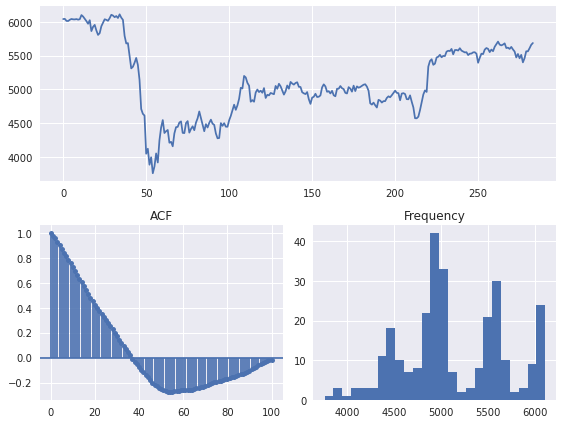

In [42]:
# In-built chart to get quick overview of a ticker
tsdisplay(y_train["^FCHI"], lag_max=100)

## ARIMA model

### Train / Test split

In [18]:
# Train / Test split
train_idx = int(y.shape[0] * train_size)
y_train = y.iloc[:train_idx]
y_test = y.iloc[train_idx:]
print(y_train.shape)
print(y_test.shape)

(284, 39)
(72, 39)


### Estimate d

In [32]:
# Use kpss and adf tests to estimate d
n_diffs = {}
for ticker in y_train.columns:
    try:
        kpss = ndiffs(y_train[ticker], alpha=0.05, test='kpss', max_d=6)
    except:
        kpss = 0
    try:
        adf = ndiffs(y_train[ticker], alpha=0.05, test='adf', max_d=6)
    except:
        adf = 0
    diffs = max(kpss, adf)
    n_diffs[ticker] = diffs

In [126]:
# print(len(n_diffs))
# print(n_diffs) # NB: n_diffs variable is now a dict, not an int.

### Fit model

In [38]:
# Train auto-arima for each ticker
auto_models = {}
for ticker in y_train.columns:
    print(f"Solving ticker {list(y_train.columns).index(ticker)+1} of {len(y_train.columns)}")
    auto = pm.auto_arima(
        y_train[ticker],
        d=n_diffs[ticker], # discovered from KPSS / ADF tests
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore",
        max_P=6,
        max_order=None,
#         trace=True,
    )
    auto_models[ticker] = auto

Solving ticker 1 of 39
Solving ticker 2 of 39
Solving ticker 3 of 39
Solving ticker 4 of 39
Solving ticker 5 of 39
Solving ticker 6 of 39
Solving ticker 7 of 39
Solving ticker 8 of 39
Solving ticker 9 of 39
Solving ticker 10 of 39
Solving ticker 11 of 39
Solving ticker 12 of 39
Solving ticker 13 of 39
Solving ticker 14 of 39
Solving ticker 15 of 39
Solving ticker 16 of 39
Solving ticker 17 of 39
Solving ticker 18 of 39
Solving ticker 19 of 39
Solving ticker 20 of 39
Solving ticker 21 of 39
Solving ticker 22 of 39
Solving ticker 23 of 39
Solving ticker 24 of 39
Solving ticker 25 of 39
Solving ticker 26 of 39
Solving ticker 27 of 39
Solving ticker 28 of 39
Solving ticker 29 of 39
Solving ticker 30 of 39
Solving ticker 31 of 39
Solving ticker 32 of 39
Solving ticker 33 of 39
Solving ticker 34 of 39
Solving ticker 35 of 39
Solving ticker 36 of 39
Solving ticker 37 of 39
Solving ticker 38 of 39
Solving ticker 39 of 39


In [40]:
# auto_models

In [60]:
# Show parameters of first model discovered by auto_arima
print(auto_models[next(iter(auto_models))].order)

(0, 1, 0)


In [57]:
# Summary report for first model
print(auto_models[next(iter(auto_models))].summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2939.923
Date:                Sat, 05 Jun 2021   AIC                           5881.847
Time:                        19:55:13   BIC                           5886.059
Sample:                             0   HQIC                          5883.500
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7672.4922    146.049     52.534      0.000    7386.241    7958.743
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              9105.20
Prob(Q):                              0.81   Pr

### Make forecast and update the model

In [63]:
# Generate forecasts and calculate MSE and SMAPE
def forecast_one_step(model):
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecast_results = {}

for ticker in y_train.columns:

    print(ticker)
    model = auto_models[ticker]
    forecasts = []
    confidence_intervals = []

    for new_ob in y_test[ticker]:
        fc, conf = forecast_one_step(model)
        forecasts.append(fc)
        confidence_intervals.append(conf)

        # Updates the existing model with a small number of MLE steps
#         print(model)
        model.update(new_ob)
    
#     print(y_test)
#     print(forecasts)
    try:
        mse_ = mean_squared_error(y_test[ticker], forecasts)
    except:
        mse_ = np.nan
    try:
        smape_ = smape(y_test[ticker], forecasts)
    except:
        smape_ = np.nan
    
    forecast_results[ticker] = (forecasts, confidence_intervals, mse_, smape_)

^FCHI
AI.PA
AIR.PA
ALO.PA
ATO.PA
CS.PA
BNP.PA
EN.PA
CAP.PA
CA.PA
ACA.PA
BN.PA
DSY.PA
ENGI.PA
EL.PA
RMS.PA
KER.PA
OR.PA
LR.PA
MC.PA
ML.PA
ORA.PA
RI.PA
PUB.PA
RNO.PA
SAF.PA
SGO.PA
SAN.PA
SU.PA
GLE.PA
STLA.PA
STM.PA
TEP.PA
HO.PA
FP.PA
VIE.PA
DG.PA
VIV.PA
WLN.PA


### Visualize forecasts

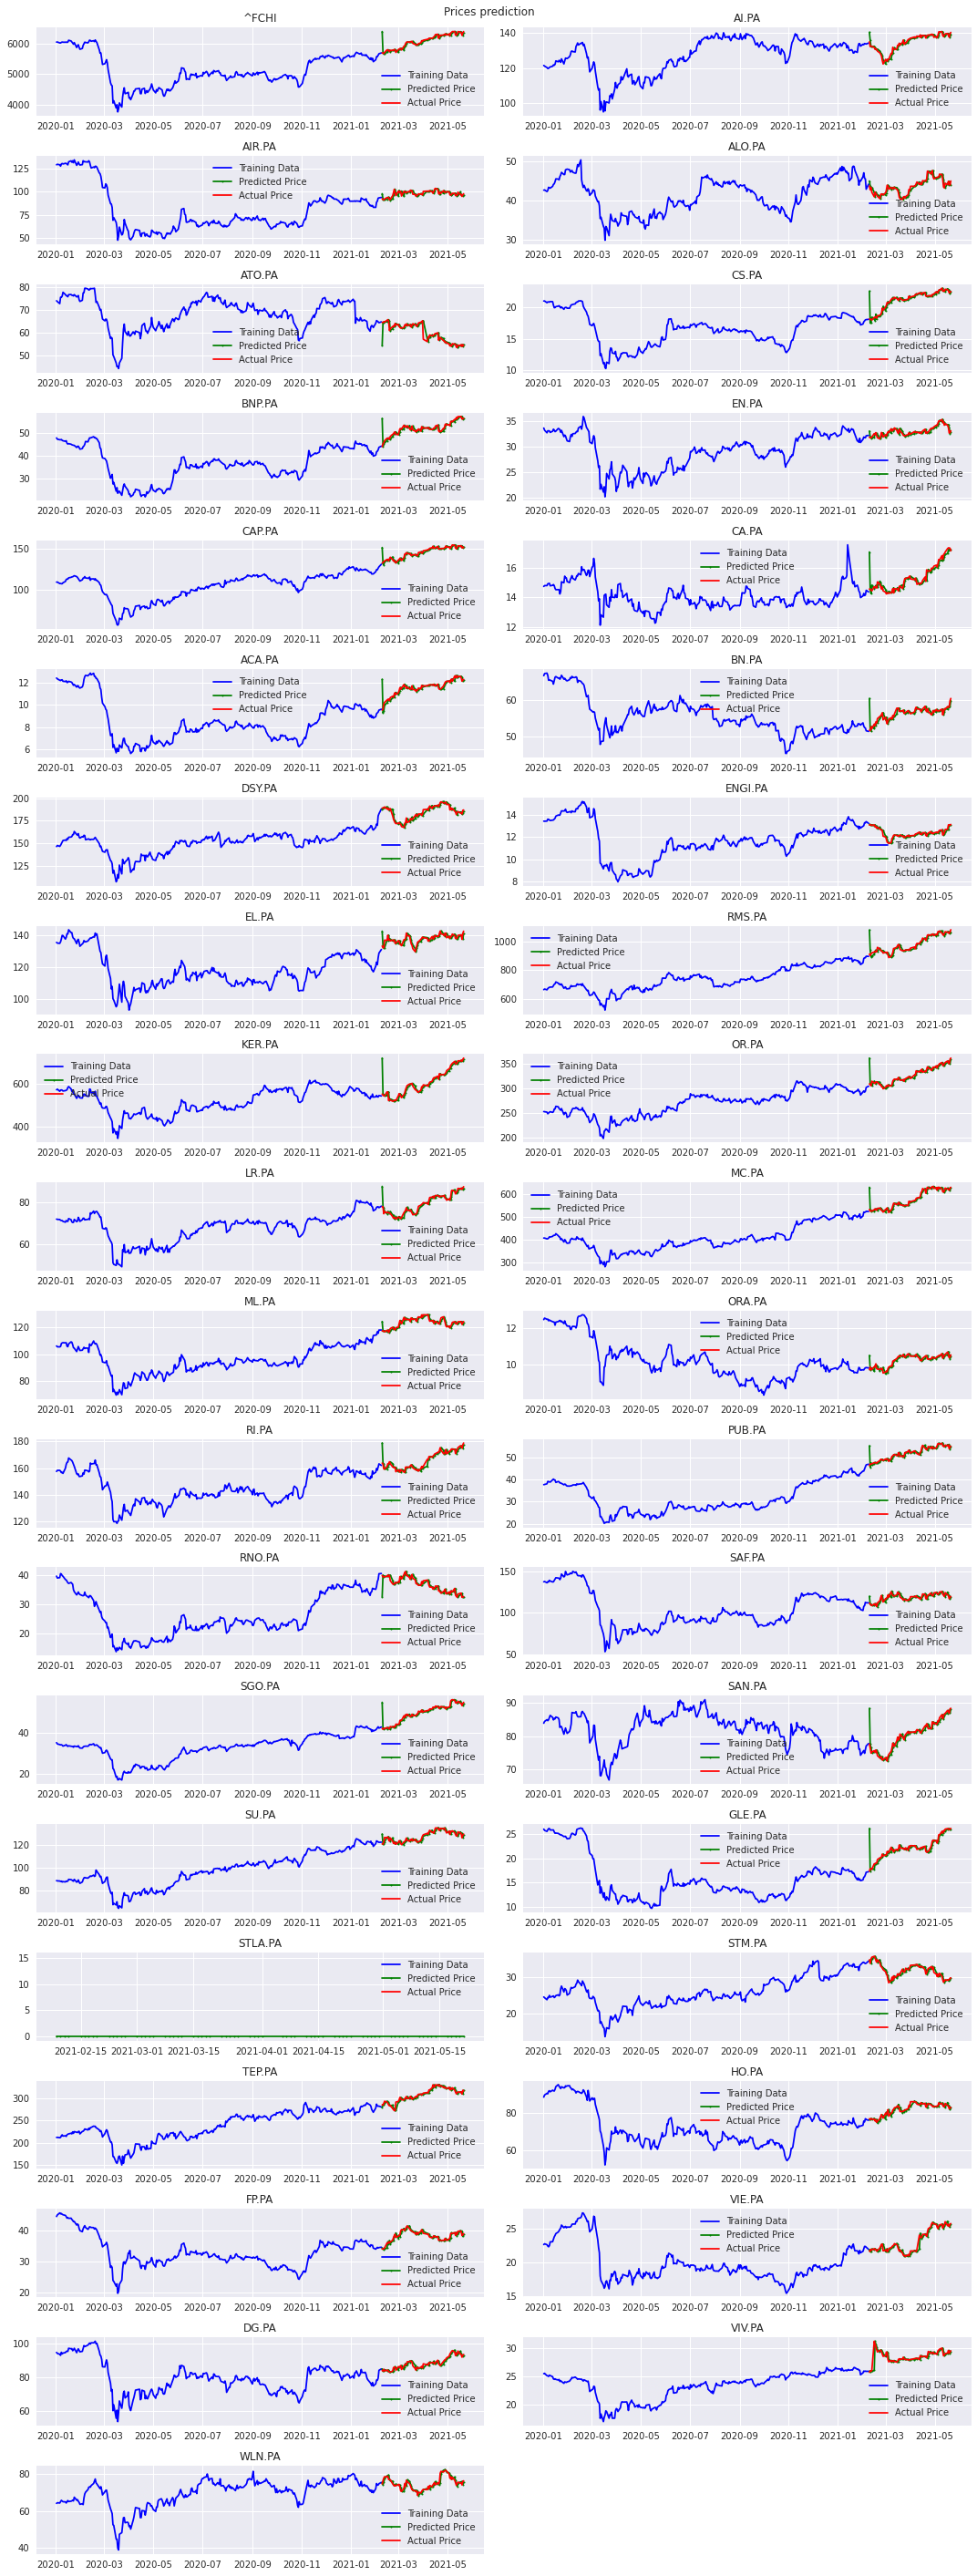

In [108]:
# Plot Actual vs Forecast for all tickers

num_subplots = len(forecast_results)
num_rows = int(np.ceil(num_subplots/2))
figheight = int(np.ceil(num_rows * 2))
# print(num_rows)
# print(figheight)

# fig, axes = plt.subplots(num_rows, 2, figsize=(15, figheight))
fig = plt.figure(figsize=(15, figheight))



for ticker in list(forecast_results.keys()):
    axnum = list(forecast_results.keys()).index(ticker)+1
    ax = fig.add_subplot(num_rows, 2, axnum)
    ax.plot(y_train[ticker], color='blue', label='Training Data')
    
    ax.plot(y_test[ticker].index, forecast_results[ticker][0], color='green', marker='o',
             markersize=2, label='Predicted Price')
    
    ax.plot(y_test[ticker].index, y_test[ticker], color='red', label='Actual Price')
    
    ax.set_title(f"{ticker}")
    ax.legend()
    
plt.suptitle("Prices prediction\n\n")
plt.tight_layout()

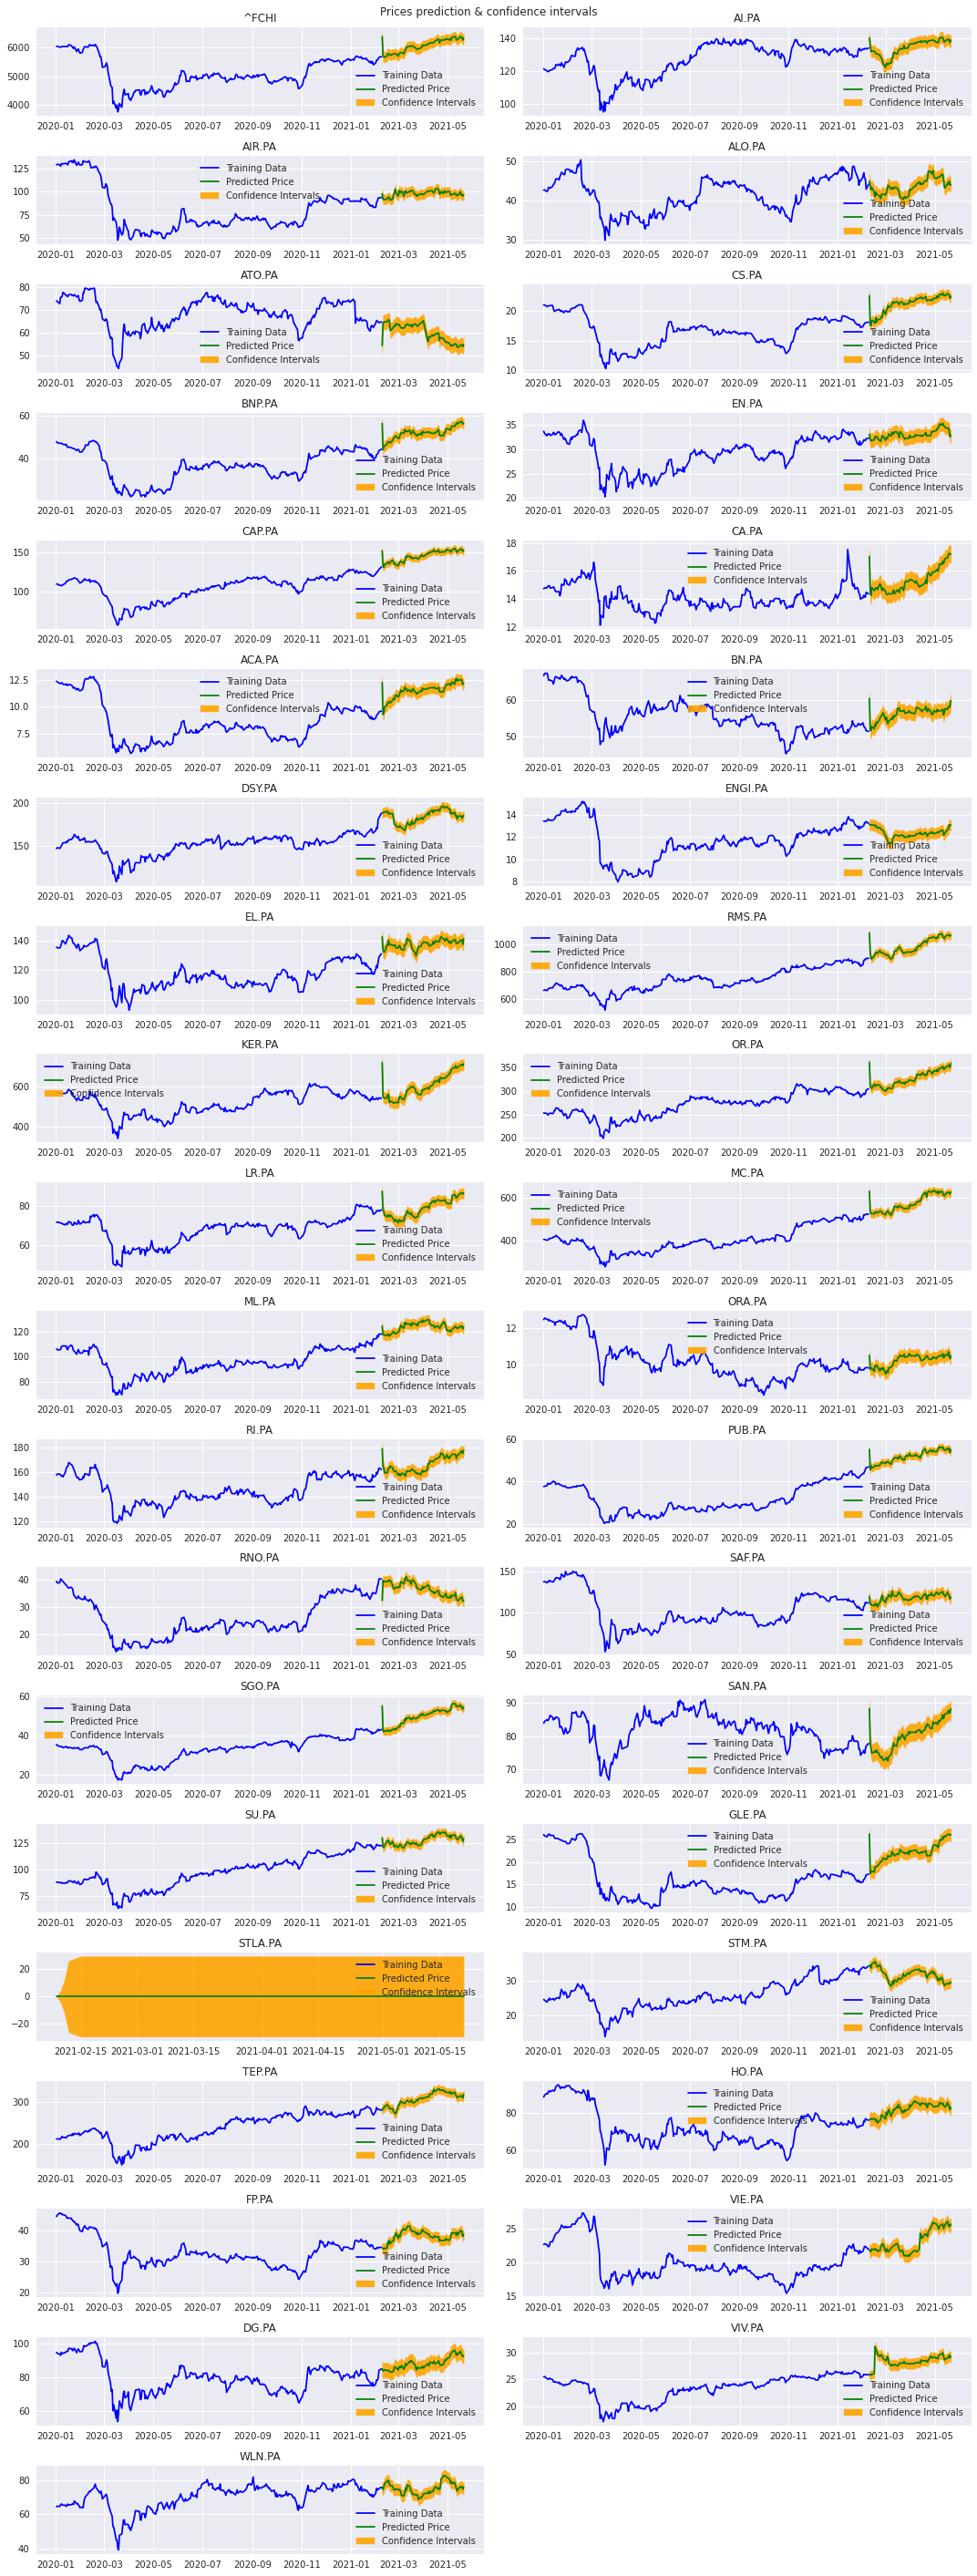

In [112]:
# Plot Predicted with Confidence levels for all tickers

num_subplots = len(forecast_results)
num_rows = int(np.ceil(num_subplots/2))
figheight = int(np.ceil(num_rows * 2))
# print(num_rows)
# print(figheight)

# fig, axes = plt.subplots(num_rows, 2, figsize=(15, figheight))
fig = plt.figure(figsize=(15, figheight))

for ticker in list(forecast_results.keys()):
    axnum = list(forecast_results.keys()).index(ticker)+1
    ax = fig.add_subplot(num_rows, 2, axnum)

    ax.plot(y_train[ticker], color='blue', label='Training Data')
    ax.plot(y_test[ticker].index, forecast_results[ticker][0], color='green',
                 label='Predicted Price')

    ax.set_title(f"{ticker}")
#     ax.set_xlabel('Dates')
#     ax.set_ylabel('Prices')

    conf_int = np.asarray(forecast_results[ticker][1])
    ax.fill_between(y_test[ticker].index,
                         conf_int[:, 0], conf_int[:, 1],
                         alpha=0.9, color='orange',
                         label="Confidence Intervals")

    # ax.set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
    ax.legend()

plt.suptitle("Prices prediction & confidence intervals\n\n")
plt.tight_layout()

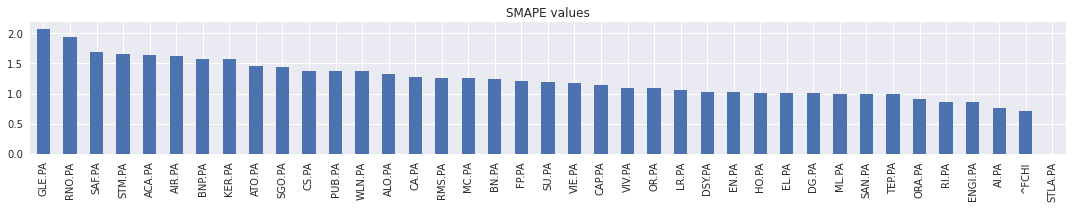

In [125]:
# Plot SMAPE values
ticker_ind = []
ticker_smapes = []
for ticker in list(forecast_results.keys()):
    ticker_smape = forecast_results[ticker][3]
    ticker_ind.append(ticker)
    ticker_smapes.append(ticker_smape)
smape_series = pd.Series(data=ticker_smapes, index=ticker_ind)
smape_series.sort_values(ascending=False, inplace=True)
smape_series.plot.bar(figsize=(15,3))
plt.title("SMAPE values")
plt.tight_layout()